In [4]:
import torch
from PIL import Image
import numpy as np
import sys,os
from pipeline.load import MyDataset

from torchvision import transforms

from tqdm import tqdm

import pipeline.criterion as Criterion
from pipeline.load import get_dataloader
import pipeline.network as Network
from torchvision.transforms.functional import to_tensor
import torch
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import pdb
import argparse
import LovaszSoftmax.pytorch.lovasz_losses as L

class ObjectView:
    '''
    Helper class to access dict values as attributes.

    Replaces command-line arg-parse options.
    '''
    def __init__(self, d):
        self.__dict__ = d
        
device = torch.device('cpu')

In [3]:
def img_frombytes(data):
    size = data.shape[::-1]
    databytes = np.packbits(data, axis=1)
    return Image.frombytes(mode='1', size=size, data=databytes)

def load_model_with_weights(model_name=None, num_epochs=8, batch_size=16, use_lovasz=False):
    '''
    Load a model by name from the /models subdirectory.
    '''

    options = {
        'use_jaccard': True,
        'use_lovasz': use_lovasz,
        'early_stopping': False,
        'validation': True,
        'model': 'encnet', # model name (default: encnet)
        'backbone': 'resnet50', # backbone name (default: resnet50)
        'jpu': True, # 'JPU'
        'dilated': True, # 'dilation'
        'lateral': False, #'employ FPN')
        'dataset':'ade20k', # 'dataset name (default: pascal12)')
        'workers': 16, # dataloader threads
        'base_size': 520, # 'base image size'
        'crop_size': 480, # 'crop image size')
        'train_split':'train', # 'dataset train split (default: train)'

        # training hyper params
        'aux': False, # 'Auxilary Loss'
        'aux_weight': 0.2, # 'Auxilary loss weight (default: 0.2)'
        'se_loss': False, # 'Semantic Encoding Loss SE-loss'
        'se_weight': 0.2, # 'SE-loss weight (default: 0.2)'
        'start_epoch': 0, # 'start epochs (default:0)'
        'batch_size': batch_size, # 'input batch size for training (default: auto)'
        'test_batch_size': None, # 'input batch size for testing (default: same as batch size)'
        'epochs':num_epochs,

        # optimizer params
        'optimizer': 'sgd',
        'lovasz_hinge': True,
        'lr': None, # 'learning rate (default: auto)'
        'lr_scheduler': 'poly', # 'learning rate scheduler (default: poly)'
        'momentum': 0.9, # 'momentum (default: 0.9)'
        'weight_decay': 1e-4, # 'w-decay (default: 1e-4)'

        # cuda, seed and logging
        'no_cuda': False, # 'disables CUDA training'
        'seed': 100, # 'random seed (default: 1)'

        # checking point
        'resume': None, # 'put the path to resuming file if needed'
        'checkname': 'default', # 'set the checkpoint name'
        'model-zoo': None, # 'evaluating on model zoo model'

        # finetuning pre-trained models
        'ft': False, # 'finetuning on a different dataset'

        # evaluation option
        'split': 'val',
        'mode': 'testval',
        'ms': False, # 'multi scale & flip'
        'no_val': False, # 'skip validation during training'
    }

    model_args = ObjectView(options)
    model = Network.get_model(model_args)

    if model_name[-5:] == '_m.pt':
        model_name = model_name[:-5]

    path_to_state_dict = 'models/{}/{}_m.pt'.format(model_name, model_name)
    model.load_state_dict(torch.load(path_to_state_dict))

    return model


In [4]:
model = load_model_with_weights(model_name="11-03-2020_12-11__full_lovasz_trial_chkpt", use_lovasz=True)
model.to(device)

EncNet(
  (pretrained): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [5]:
dataset = MyDataset(in_dir="training_data")
region = '825a50'
indices = [dataset.basenames.index(file)for file in dataset.basenames if file[:6] == region]
indices

training_data
training_data/images/*.jpg


[118,
 1204,
 1371,
 1426,
 2883,
 3335,
 4018,
 4416,
 5318,
 5644,
 6967,
 7238,
 7894,
 7896,
 10517,
 12209,
 13060,
 13138,
 13557,
 17063,
 17133,
 17136,
 17950,
 18232,
 18983,
 19584,
 19748,
 19924,
 20344,
 20811,
 22248,
 23734,
 23739,
 24273,
 25894,
 26137,
 26973,
 27218,
 27639,
 27716,
 27927,
 28798,
 29570,
 31461,
 32681,
 35234,
 35709,
 35716,
 36203,
 36718,
 37538,
 37782,
 38318,
 39006,
 39332,
 41390,
 41455,
 41492,
 41521,
 42664,
 43105,
 43130,
 43865,
 43973,
 44200]

In [12]:
def display_pred(scene=None, file=None, threshold=0, index=None):
    dataset = MyDataset(in_dir="training_data")
    assert None in [scene, file], "Can't use both scene and file arguments"
    if file is not None:
        index = dataset.basenames.index(file)
    elif scene is not None:
        scene_indices = [dataset.basenames.index(file)for file in dataset.basenames if file[:6] == scene]
        if index is None:
            index = np.random.choice(scene_indices) 
    elif index is None:
        index = np.random.randint(0, len(dataset))
    image_tuple=dataset[index]
    print(image_tuple[2])
    inputs = to_tensor(image_tuple[0]).unsqueeze(0).to(device)
    mask = to_tensor(image_tuple[1])
    with torch.no_grad():
        prediction = model(inputs)
    fig, ax = plt.subplots(ncols=4, figsize=(40,10))
    ax[0].imshow(image_tuple[0])
    ax[1].imshow(image_tuple[1])
    ax[2].imshow(prediction[0].cpu().squeeze())
    ax[3].imshow((prediction[0]>threshold).cpu().squeeze())
    fig.suptitle('IoU score: '+str(L.iou_binary(mask, (prediction[0]>threshold).cpu()))+'\nindex: '+str(index), fontsize=50)
    return prediction
#     ax[3].imshow(prediction[2].argmax(dim=1).cpu().squeeze())

In [7]:
with torch.no_grad():
    pred = model(to_tensor(dataset[8326][0]).unsqueeze(0).to(device))

In [225]:
plt.suptitle(

SyntaxError: invalid syntax (<ipython-input-225-5324d72c27a2>, line 1)

In [8]:
L.iou_binary(to_tensor(dataset[22354][1]).squeeze().to(device), pred[0].squeeze())

20.01953125

training_data
training_data/images/*.jpg
training_data/images/825a50_3072_7168_i.jpg


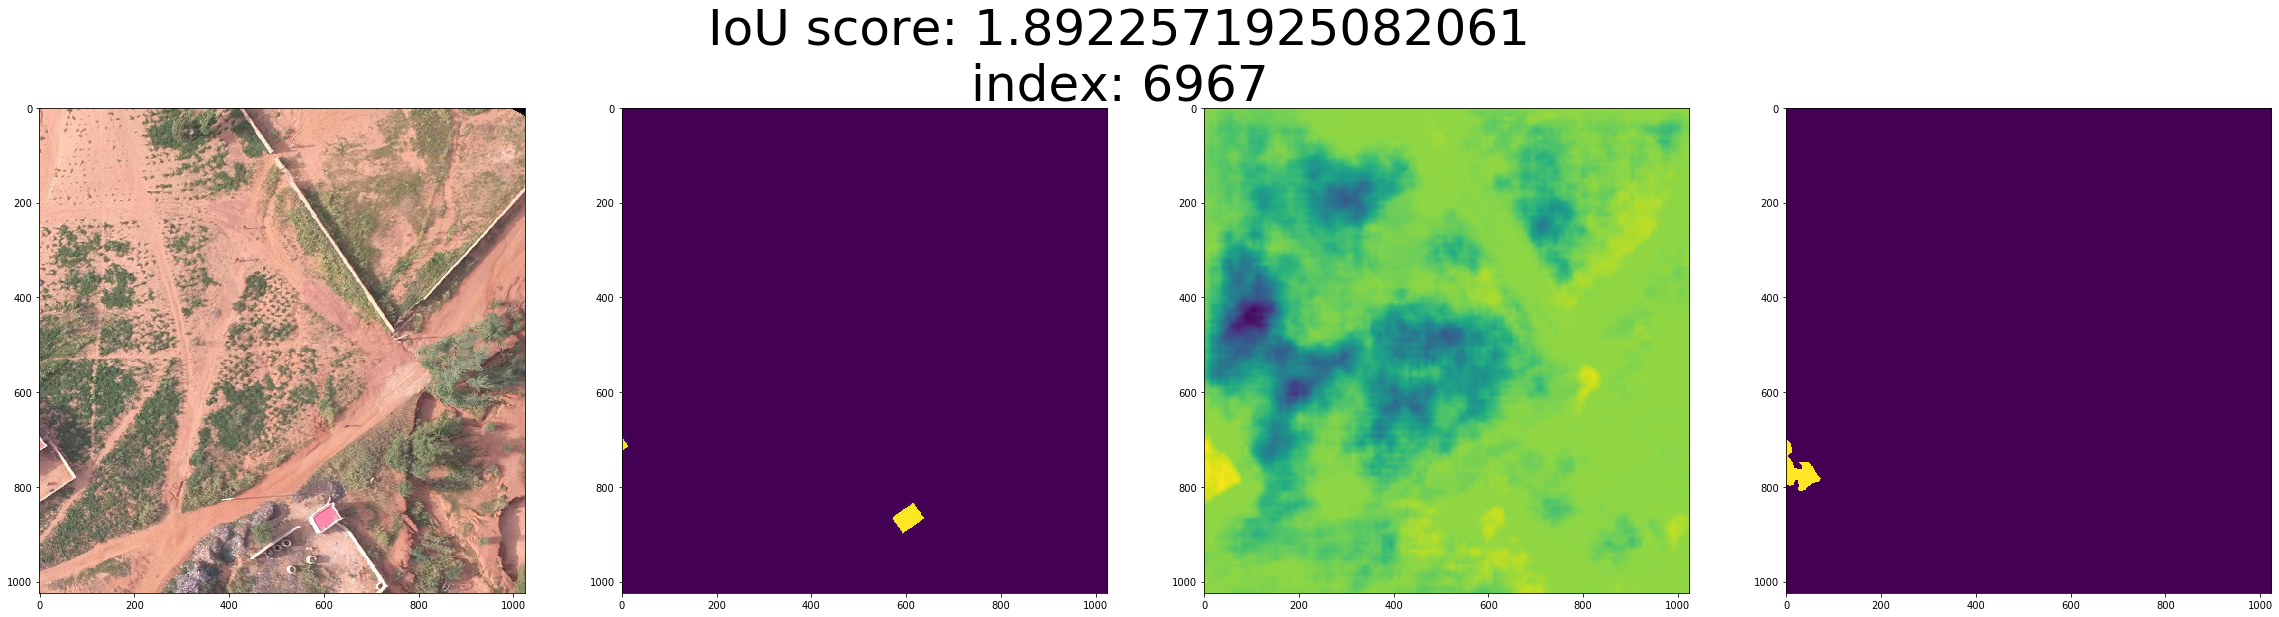

In [26]:
pred = display_pred(file='825a50_6144_1024_i.jpg')

In [27]:
pred[0].squeeze().shape

torch.Size([1024, 1024])

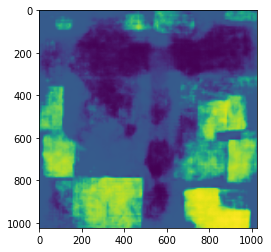

In [295]:
plt.imshow(F.sigmoid(pred[0].cpu().squeeze()))

In [5]:
from pipeline.network import BaseNet
from FastFCN.encoding import dilated as resnet
base = BaseNet(2, 'resnet101', False, False, dilated=True, norm_layer=torch.nn.BatchNorm2d)

Model file /home/alex_e_weston_gmail_com/.encoding/models/resnet101-2a57e44d.pth is not found. Downloading.


100%|██████████| 100160/100160 [00:15<00:00, 6580.90KB/s]


In [61]:
def layer_gen(model):
    yield from reversed(list(model.pretrained.layer4.children()))
    yield from reversed(list(model.pretrained.layer3.children()))
    yield from reversed(list(model.pretrained.layer2.children()))
    yield from reversed(list(model.pretrained.layer1.children()))
mygen = layer_gen(base)

In [65]:
next(mygen)

Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [49]:
def layer_gen(model):
    yield from in reversed(list(model.layer4.children))
    yield from in reversed(list(model.layer3.children))
    yield from in reversed(list(model.layer2.children))
    yield from in reversed(list(model.layer1.children))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, mom

In [67]:
params = [p for p in base.parameters() if p.requires_grad]

In [68]:
optimizer = torch.optim.SGD(params, lr=0.1, momentum=0.9)

In [103]:
for group in optimizer.param_groups:
    print(group['lr'])

0.0125
0.00125
0.01


In [84]:
base.pretrained.layer4[-2].requires_grad_()
grp ={"params": base.pretrained.layer4[-3].parameters(), "lr":0.01, 'name':'conv2'}

In [90]:
optimizer.add_param_group(grp)

ValueError: some parameters appear in more than one parameter group

In [102]:
for i in reversed(optimizer.param_groups[:-1]):
    i['lr'] = i['lr']/2